# Understanding RNNs

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.basics import *
import math
import jkbc.types as t

## 5 Examples of Simple Sequence Prediction Problems for LSTMs
From: https://machinelearningmastery.com/sequence-prediction-problems-learning-lstm-recurrent-neural-networks/

### 1. Sequence Learning Problem

In [69]:
# generate a sequence of real values between 0 and 1.
def generate_sequence(length : int = 10) -> torch.Tensor:
	return torch.tensor([i/float(length) for i in range(length)])
 
print(generate_sequence())

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])


In [127]:
# Predict next number in sequence
N = 10000
x = generate_sequence(N).view((N,1))
y = torch.cat((x[1:], x[:1])).view((N, 1)) # add 0.0 as last element
x.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [6]:
map_t = lambda f, x : torch.tensor(list(map(f, x)))
def assert_pct(pct, name): assert 0.0 <= pct <= 1.0, f'{name} must be a float between 0.0 and 1.0'

def split_into_databunch(x: torch.Tensor, y: torch.Tensor, bs: int = 64, pct_train: float = 0.8, pct_valid: float = 0.2, pct_test: float = 0.0) -> DataBunch:
    '''Takes the first `split` percentage of the tensors as training data and returns a databunch.'''
    len_x, len_y = len(x), len(y)
    assert len_x == len_y, 'x and y must have the same length'

    assert_pct(pct_train, 'pct_train'); assert_pct(pct_valid, 'pct_valid'); assert_pct(pct_test, 'pct_test')
    
    assert math.isclose(pct_train+pct_valid+pct_test, 1.0), 'pct_train + pct_valid + pct_test must add up to 1.0'
    
    split_train_valid = round(len_x * pct_train)
    split_valid_test = split_train_valid + round(len_x * pct_valid)
        
    # [training data || validation data || test data ]
    ds_train = TensorDataset(x[:split_train_valid], y[:split_train_valid])
    ds_valid = TensorDataset(x[split_train_valid:split_valid_test], y[split_train_valid:split_valid_test])
    
    if pct_test == 0.0:
        ds_test = None
    else:
        ds_test = TensorDataset(x[split_valid_test:], y[split_valid_test:])
    
    return DataBunch.create(ds_train, ds_valid, test_ds = ds_test, bs = bs)

In [130]:
# Create databunch
split = 0.8
BS = 64
data = split_into_databunch(x, y, BS, pct_train=0.7, pct_valid=0.2, pct_test=0.1)
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([64, 1]), torch.Size([64, 1]))

In [404]:
model = nn.Sequential(
    nn.Linear(1, 1),
    nn.Linear(20, 1),
).cuda()

In [132]:
learner = Learner(data, model, loss_func=mean_squared_error)

In [365]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: The size of tensor a (100) must match the size of tensor b (64) at non-singleton dimension 1

Min numerical gradient: 2.09E-03
Min loss divided by 10: 7.59E-02


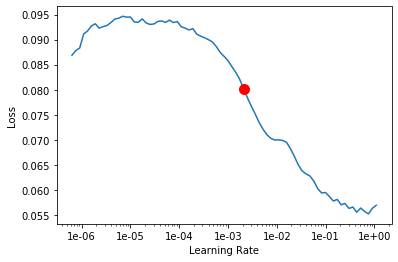

In [134]:
learner.recorder.plot(suggestion=True)

In [135]:
learner.fit_one_cycle(10, max_lr=2.09e-03)

epoch,train_loss,valid_loss,time
0,0.034063,0.067410,00:00
1,0.007824,0.004566,00:00
2,0.000899,0.000000,00:00
3,0.000099,0.000000,00:00
4,0.000011,0.000000,00:00
5,0.000001,0.000000,00:00
6,0.000000,0.000000,00:00
7,0.000000,0.000000,00:00
8,0.000000,0.000000,00:00
9,0.000000,0.000000,00:00


In [ ]:
xb[:10], yb[:10], model(xb[:10].cuda())

In [ ]:
learner.validate(data.test_dl)
data.test_dl.tensors[0][:10], model(data.test_dl.tensors[0][:10].cuda())

## Value Memorization

The problem is to remember the first element of the sequence and repeat it in the end. Here it is a many -> one sequence prediction:

In [377]:
def gen_memorization_seq(data_size: int, seq_length: int, max_val: int) -> t.Tuple[torch.Tensor, torch.Tensor]:
    x = torch.randint(low = 0, high = max_val, size=(data_size, seq_length, 1), dtype=torch.float32)
    y = x[:,0,:] # let y be the same as the first value in the sequence
    return x, y

In [378]:
N = 10_000
seq_length = 100
max_val = 10
BS = 64
dim_in = 1
dim_h = 50
num_layers = 5

In [379]:
x, y = gen_memorization_seq(N, seq_length, max_val); x.shape, y.shape

(torch.Size([10000, 100, 1]), torch.Size([10000, 1]))

In [380]:
data = split_into_databunch(x, y, BS)

In [405]:
class ThrowAwayHidden(nn.Module):
    def __init__(self, inner_model: nn.Module):
        super().__init__()
        self.inner_model = inner_model  
    def forward(self, xb): return self.inner_model(xb)[0]

In [406]:
rnn = nn.RNN(input_size=dim_in, hidden_size=dim_h, num_layers=num_layers, batch_first=True)

In [407]:
model = nn.Sequential(
    ThrowAwayHidden(rnn),
    nn.Linear(dim_h, dim_in),
    nn.Flatten(),
).cuda()

In [408]:
xb,yb = data.one_batch()
xb = xb.cuda()
xb.shape, model(xb).shape, yb.shape

(torch.Size([64, 100, 1]), torch.Size([64, 100]), torch.Size([64, 1]))

In [409]:
learner = Learner(data, model, loss_func=torch.functional.F.mse_loss)

In [410]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 7.59E-02


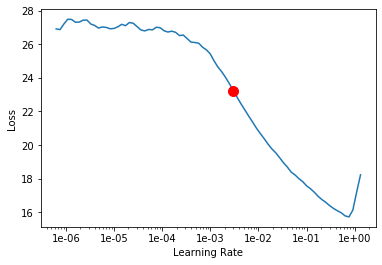

In [400]:
learner.recorder.plot(suggestion=True)

In [411]:
learner.fit_one_cycle(10, max_lr=learner.recorder.min_grad_lr);

AttributeError: 'Learner' object has no attribute 'min_grad_lr'

In [308]:
lstm = nn.LSTM(input_size=dim_in, hidden_size=dim_h, num_layers=5, batch_first=True)

In [310]:
model_lstm = nn.Sequential(
    ThrowAwayHidden(lstm),
    nn.Flatten(),
    nn.Linear(seq_length*dim_h, 1),
).cuda()

In [311]:
learner_lstm = Learner(data, model_lstm, loss_func=mean_squared_error)

In [312]:
learner_lstm.lr_find()

epoch,train_loss,valid_loss,time
0,16.936842,#na#,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 2.29E-01


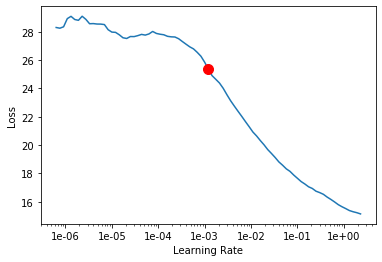

In [313]:
learner_lstm.recorder.plot(suggestion=True)

In [314]:
learner_lstm.fit_one_cycle(10, max_lr=learner_lstm.recorder.min_grad_lr)

epoch,train_loss,valid_loss,time
0,15.346609,8.165193,00:02
1,9.460642,8.168337,00:02
2,8.642915,8.183803,00:02
3,8.438144,8.273639,00:02
4,5.678027,1.694387,00:02
5,1.361109,0.100568,00:02
6,0.328028,0.053477,00:02
7,0.099906,0.048595,00:02
8,0.045373,0.029391,00:02
9,0.032416,0.027778,00:02


In [386]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layer_dim):
        super(self).__init__()
        self.h0 = 

    def forward(self, input):
        
        return output

In [451]:
x = torch.tensor([99])
L1 = torch.tensor([1,0,0,0]).view((4,1))
L2 = torch.tensor([ [0,0,0,0]
                  , [1,0,0,0]
                  , [0,1,0,0]
                  , [0,0,1,0]])
L3 = torch.tensor([0,0,0,1]).view((4,1))
H = torch.tensor([10,20,30,40]).view((4,1))

In [441]:
V1 = L1 * x;
V1.shape, V1

(torch.Size([4, 1]),
 tensor([[99],
         [ 0],
         [ 0],
         [ 0]]))

In [447]:
V2 = L2 @ H
L2.shape, H.shape, V2.shape, V2

(torch.Size([4, 4]),
 torch.Size([4, 1]),
 torch.Size([4, 1]),
 tensor([[ 0],
         [10],
         [20],
         [30]]))

In [448]:
H_ = V1 + V2
V1.shape, V2.shape, H_.shape, H

(torch.Size([4, 1]),
 torch.Size([4, 1]),
 torch.Size([4, 1]),
 tensor([[10],
         [20],
         [30],
         [40]]))

In [452]:
L3_t = L3.t()
O = L3_t @ H_
L3_t.shape, H_.shape, O.shape, O

(torch.Size([1, 4]), torch.Size([4, 1]), torch.Size([1, 1]), tensor([[30]]))

## One-To-One
https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/

In [62]:
N = 20
BS = 5

In [63]:
x = torch.tensor([x+1. for x in range(N)])
y = torch.tensor([y*15. for y in x])
x.shape, y.shape

(torch.Size([20]), torch.Size([20]))

In [64]:
# Reshape to (samples, time_steps, features) AKA (batch_size, seq_length, features)
x = x.view((N, 1, 1))
y = y.view((N, 1))

In [65]:
class LSTM1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 50, batch_first=True)
        self.relu = nn.ReLU()
        self.lin = nn.Linear(50, 1)
        self.cn = torch.randn()
    
    def forward(self, xb):
        xb_, _ = self.lstm(xb)
        return self.lin(self.relu(xb_))

In [66]:
data = split_into_databunch(x, y, bs=BS)

In [67]:
learn = Learner(data, LSTM1().cuda(), loss_func=mean_squared_error)

Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-06


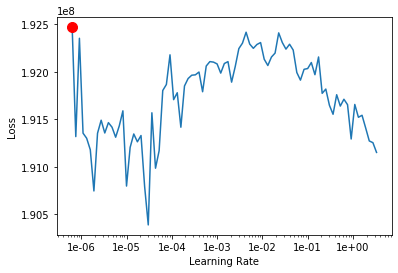

In [60]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1000)

In [77]:
xt = torch.tensor([30.]).view((1,1,1)).cuda()
learn.model(xt)

tensor([[[234.1305]]], device='cuda:0', grad_fn=<AddBackward0>)

## Many-To-One

In [10]:
BS = 15
seq_len = 3
feature_len = 1
N = 450
N2 = N // seq_len

In [12]:
x = torch.tensor([x + 1. for x in range(N)]).view((N2, seq_len, feature_len))
y = x[:, 0, :]
list(zip(x, y))[:2] # x: (a, b, c), y: a+b+c

[(tensor([[1.],
          [2.],
          [3.]]),
  tensor([1.])),
 (tensor([[4.],
          [5.],
          [6.]]),
  tensor([4.]))]

In [13]:
data = split_into_databunch(x, y, bs=BS)

In [120]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, initial_bs):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.lin = nn.Linear(hidden_size, 1)
    
    def forward(self, xb):
        out, _ = self.rnn(xb)
        out = self.relu(out)
        out = self.lin(out)
        return out[:,-1,:] # just return last value from sequence

In [121]:
model = LSTM1(input_size=1, hidden_size=10, num_layers=1, initial_bs=BS).cuda()

In [122]:
learn = Learner(data, model, loss_func=mean_squared_error)

In [ ]:
tx = torch.tensor([101.,102,103]).cuda().view((1,3,1)) 
model(tx)

epoch,train_loss,valid_loss,time
0,23598.958984,#na#,00:00
1,23739.378906,#na#,00:00
2,23746.074219,#na#,00:00
3,23734.130859,#na#,00:00
4,23705.910156,#na#,00:00
5,23700.269531,#na#,00:00
6,23710.349609,#na#,00:00
7,23720.082031,#na#,00:00
8,23686.097656,#na#,00:00
9,23533.501953,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-01


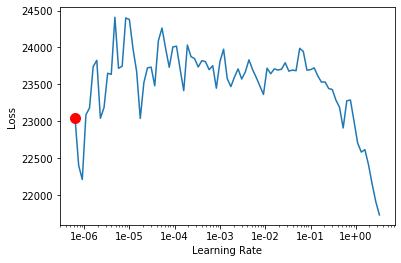

In [130]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1000)

epoch,train_loss,valid_loss,time
0,23502.255859,114901.507812,00:00
1,23622.109375,114897.546875,00:00
2,23563.027344,114893.500000,00:00
3,23490.962891,114889.414062,00:00
4,23515.150391,114885.375000,00:00
5,23546.482422,114881.375000,00:00
6,23525.066406,114877.265625,00:00
7,23548.542969,114873.164062,00:00
8,23543.080078,114869.000000,00:00
9,23575.152344,114864.781250,00:00


Exception ignored in: <function _releaseLock at 0x7f17856ce830>
Traceback (most recent call last):
  File "/user/student.aau.dk/kbargs15/.conda/envs/jkbc/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
